In [1]:
# For gpt_similarity_detection.py and gemini_similarity_detection.py
# Just change the paths from 'Data/GPT-4o/' to 'Data/Gemini/' for the Gemini version

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# First set of functions using all-mpnet-base-v1
def create_embeddings_and_analyze(df, model_name='sentence-transformers/all-mpnet-base-v1'):
    """
    Create embeddings using SentenceTransformer and analyze similarities for both
    separate title/body responses and combined responses
    """
    # Initialize the model
    model = SentenceTransformer(model_name)
    
    # Generate embeddings for original content
    print("Generating embeddings for original content...")
    title_embeddings = model.encode(df['Title'].tolist(), show_progress_bar=True)
    body_embeddings = model.encode(df['Body'].tolist(), show_progress_bar=True)
    title_body_embeddings = model.encode(df['Title_Body'].tolist(), show_progress_bar=True)
    
    # Generate embeddings for LLM responses
    print("\nGenerating embeddings for LLM responses...")
    response_embeddings = {
        # Title responses
        'zero_shot_title': model.encode(df['llm_zero_shot_title'].tolist(), show_progress_bar=True),
        'few_shot_title': model.encode(df['llm_few_shot_title'].tolist(), show_progress_bar=True),
        'cot_title': model.encode(df['llm_cot_title'].tolist(), show_progress_bar=True),
        
        # Body responses
        'zero_shot_body': model.encode(df['llm_zero_shot_body'].tolist(), show_progress_bar=True),
        'few_shot_body': model.encode(df['llm_few_shot_body'].tolist(), show_progress_bar=True),
        'cot_body': model.encode(df['llm_cot_body'].tolist(), show_progress_bar=True),
        
        # Combined responses
        'zero_shot_combined': model.encode(df['llm_zero_shot_combined'].tolist(), show_progress_bar=True),
        'few_shot_combined': model.encode(df['llm_few_shot_combined'].tolist(), show_progress_bar=True),
        'cot_combined': model.encode(df['llm_cot_combined'].tolist(), show_progress_bar=True)
    }
    
    # Calculate similarities
    similarities = {
        'title': {},
        'body': {},
        'combined': {}
    }
    
    # Calculate similarities for each type
    for response_type in ['zero_shot', 'few_shot', 'cot']:
        similarities['title'][response_type] = np.diagonal(
            cosine_similarity(title_embeddings, response_embeddings[f'{response_type}_title'])
        )
        similarities['body'][response_type] = np.diagonal(
            cosine_similarity(body_embeddings, response_embeddings[f'{response_type}_body'])
        )
        similarities['combined'][response_type] = np.diagonal(
            cosine_similarity(title_body_embeddings, response_embeddings[f'{response_type}_combined'])
        )
    
    # Add similarity scores to dataframe
    for response_type in ['zero_shot', 'few_shot', 'cot']:
        df[f'similarity_{response_type}_title'] = similarities['title'][response_type]
        df[f'similarity_{response_type}_body'] = similarities['body'][response_type]
        df[f'similarity_{response_type}_combined'] = similarities['combined'][response_type]
    
    # Save embeddings (using GPT-4o path - change to Gemini for gemini version)
    np.save('Data/llama-3.2/title_embeddings_st.npy', title_embeddings)
    np.save('Data/llama-3.2/body_embeddings_st.npy', body_embeddings)
    np.save('Data/llama-3.2/title_body_embeddings_st.npy', title_body_embeddings)
    
    for response_type, embeddings in response_embeddings.items():
        np.save(f'Data/llama-3.2/{response_type}_embeddings_st.npy', embeddings)
    
    return df, similarities

# Second set using MiniLM
def create_embeddings_and_analyze_minilm(df):
    return create_embeddings_and_analyze(df, model_name='sentence-transformers/all-MiniLM-L6-v2')

# Third set using KartonBERT
def create_embeddings_and_analyze_kartonbert(df, model_name='OrlikB/KartonBERT-USE-base-v1'):
    """
    Create embeddings using KartonBERT and analyze similarities with normalized embeddings
    """
    # Initialize the model
    model = SentenceTransformer(model_name)
    
    # Generate embeddings for original content
    print("Generating embeddings for original content...")
    title_embeddings = model.encode(df['Title'].tolist(), normalize_embeddings=True, show_progress_bar=True)
    body_embeddings = model.encode(df['Body'].tolist(), normalize_embeddings=True, show_progress_bar=True)
    title_body_embeddings = model.encode(df['Title_Body'].tolist(), normalize_embeddings=True, show_progress_bar=True)
    
    # Generate embeddings for LLM responses
    print("\nGenerating embeddings for LLM responses...")
    response_embeddings = {
        # Title responses
        'zero_shot_title': model.encode(df['llm_zero_shot_title'].tolist(), normalize_embeddings=True, show_progress_bar=True),
        'few_shot_title': model.encode(df['llm_few_shot_title'].tolist(), normalize_embeddings=True, show_progress_bar=True),
        'cot_title': model.encode(df['llm_cot_title'].tolist(), normalize_embeddings=True, show_progress_bar=True),
        
        # Body responses
        'zero_shot_body': model.encode(df['llm_zero_shot_body'].tolist(), normalize_embeddings=True, show_progress_bar=True),
        'few_shot_body': model.encode(df['llm_few_shot_body'].tolist(), normalize_embeddings=True, show_progress_bar=True),
        'cot_body': model.encode(df['llm_cot_body'].tolist(), normalize_embeddings=True, show_progress_bar=True),
        
        # Combined responses
        'zero_shot_combined': model.encode(df['llm_zero_shot_combined'].tolist(), normalize_embeddings=True, show_progress_bar=True),
        'few_shot_combined': model.encode(df['llm_few_shot_combined'].tolist(), normalize_embeddings=True, show_progress_bar=True),
        'cot_combined': model.encode(df['llm_cot_combined'].tolist(), normalize_embeddings=True, show_progress_bar=True)
    }
    
    # Calculate similarities using dot product
    similarities = {
        'title': {},
        'body': {},
        'combined': {}
    }
    
    # Calculate similarities for each type
    for response_type in ['zero_shot', 'few_shot', 'cot']:
        similarities['title'][response_type] = np.sum(
            title_embeddings * response_embeddings[f'{response_type}_title'], axis=1
        )
        similarities['body'][response_type] = np.sum(
            body_embeddings * response_embeddings[f'{response_type}_body'], axis=1
        )
        similarities['combined'][response_type] = np.sum(
            title_body_embeddings * response_embeddings[f'{response_type}_combined'], axis=1
        )
    
    # Add similarity scores to dataframe
    for response_type in ['zero_shot', 'few_shot', 'cot']:
        df[f'similarity_{response_type}_title'] = similarities['title'][response_type]
        df[f'similarity_{response_type}_body'] = similarities['body'][response_type]
        df[f'similarity_{response_type}_combined'] = similarities['combined'][response_type]
    
    # Save embeddings (using GPT-4o path - change to Gemini for gemini version)
    np.save('Data/llama-3.2/title_embeddings_kartonbert.npy', title_embeddings)
    np.save('Data/llama-3.2/body_embeddings_kartonbert.npy', body_embeddings)
    np.save('Data/llama-3.2/title_body_embeddings_kartonbert.npy', title_body_embeddings)
    
    for response_type, embeddings in response_embeddings.items():
        np.save(f'Data/llama-3.2/{response_type}_embeddings_kartonbert.npy', embeddings)
    
    return df, similarities

def analyze_similarities(similarities):
    """
    Analyze and visualize similarity distributions for title, body, and combined responses
    """
    categories = {
        'Very High': (0.8, 1.0),
        'High': (0.6, 0.8),
        'Moderate': (0.4, 0.6),
        'Low': (0.2, 0.4),
        'Very Low': (0.0, 0.2)
    }
    
    results = {
        'title': {},
        'body': {},
        'combined': {}
    }
    
    # Create figures for each type of response
    for response_category in ['title', 'body', 'combined']:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'Similarity Analysis for {response_category.capitalize()} Responses')
        
        for idx, response_type in enumerate(['zero_shot', 'few_shot', 'cot']):
            scores = similarities[response_category][response_type]
            
            stats = {
                'mean': np.mean(scores),
                'median': np.median(scores),
                'std': np.std(scores),
                'min': np.min(scores),
                'max': np.max(scores)
            }
            
            distribution = {}
            for category, (low, high) in categories.items():
                count = np.sum((scores >= low) & (scores < high))
                percentage = (count / len(scores)) * 100
                distribution[category] = percentage
                
            results[response_category][response_type] = {
                'statistics': stats,
                'distribution': distribution
            }
            
            ax = axes[idx]
            sns.histplot(scores, bins=30, ax=ax)
            ax.set_title(f'{response_type.replace("_", " ").title()}')
            ax.set_xlabel('Similarity Score')
            ax.set_ylabel('Count')
            
            for category, (low, high) in categories.items():
                if low > 0:
                    ax.axvline(x=low, color='r', linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        # Save plot (using GPT-4o path - change to Gemini for gemini version)
        plt.savefig(f'Data/llama-3.2/similarity_distributions_{response_category}_st.png')
        plt.close()
    
    # Print analysis
    for response_category in ['title', 'body', 'combined']:
        print(f"\n{response_category.upper()} Response Analysis:")
        for response_type, result in results[response_category].items():
            print(f"\n{response_type.upper()}:")
            print("\nBasic Statistics:")
            for metric, value in result['statistics'].items():
                print(f"{metric}: {value:.4f}")
            
            print("\nDistribution across categories:")
            for category, percentage in result['distribution'].items():
                print(f"{category}: {percentage:.2f}%")
    
    return results

# Main execution
if __name__ == "__main__":
    # Read the combined CSV file (using GPT-4o path - change to Gemini for gemini version)
    df = pd.read_csv('Data/llama-3.2/llm_responses_combined.csv')
    
    # Run analysis with all three models
    
    # all-mpnet-base-v1
    df_with_similarities, similarities = create_embeddings_and_analyze(df)
    analysis_results = analyze_similarities(similarities)
    df_with_similarities.to_csv('Data/llama-3.2/llm_responses_with_similarities_st.csv', index=False)
    
    # all-MiniLM-L6-v2
    df_with_similarities_minilm, similarities_minilm = create_embeddings_and_analyze_minilm(df)
    analysis_results_minilm = analyze_similarities(similarities_minilm)
    df_with_similarities_minilm.to_csv('Data/llama-3.2/llm_responses_with_similarities_st_minilm.csv', index=False)
    
    # KartonBERT
    df_with_similarities_kartonbert, similarities_kartonbert = create_embeddings_and_analyze_kartonbert(df)
    analysis_results_kartonbert = analyze_similarities(similarities_kartonbert)
    df_with_similarities_kartonbert.to_csv('Data/llama-3.2/llm_responses_with_similarities_kartonbert.csv', index=False)

Generating embeddings for original content...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Generating embeddings for LLM responses...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]


TITLE Response Analysis:

ZERO_SHOT:

Basic Statistics:
mean: 0.2018
median: 0.1416
std: 0.2105
min: -0.1047
max: 0.9072

Distribution across categories:
Very High: 1.40%
High: 3.50%
Moderate: 11.89%
Low: 23.78%
Very Low: 46.15%

FEW_SHOT:

Basic Statistics:
mean: 0.0433
median: 0.0312
std: 0.1076
min: -0.1458
max: 0.5320

Distribution across categories:
Very High: 0.00%
High: 0.00%
Moderate: 2.80%
Low: 2.80%
Very Low: 61.54%

COT:

Basic Statistics:
mean: 0.2100
median: 0.1468
std: 0.2110
min: -0.0901
max: 0.9859

Distribution across categories:
Very High: 1.40%
High: 5.59%
Moderate: 12.59%
Low: 20.98%
Very Low: 48.95%

BODY Response Analysis:

ZERO_SHOT:

Basic Statistics:
mean: 0.2535
median: 0.2073
std: 0.2123
min: -0.1515
max: 0.8100

Distribution across categories:
Very High: 0.70%
High: 6.99%
Moderate: 17.48%
Low: 27.27%
Very Low: 39.86%

FEW_SHOT:

Basic Statistics:
mean: 0.0500
median: 0.0331
std: 0.0978
min: -0.1428
max: 0.4029

Distribution across categories:
Very High: 0.0

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Generating embeddings for LLM responses...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]


TITLE Response Analysis:

ZERO_SHOT:

Basic Statistics:
mean: 0.2106
median: 0.1645
std: 0.2167
min: -0.1702
max: 0.9559

Distribution across categories:
Very High: 1.40%
High: 4.90%
Moderate: 9.79%
Low: 23.08%
Very Low: 46.85%

FEW_SHOT:

Basic Statistics:
mean: 0.0436
median: 0.0371
std: 0.1158
min: -0.1474
max: 0.6026

Distribution across categories:
Very High: 0.00%
High: 0.70%
Moderate: 1.40%
Low: 4.90%
Very Low: 53.85%

COT:

Basic Statistics:
mean: 0.2195
median: 0.1624
std: 0.2191
min: -0.1978
max: 0.9854

Distribution across categories:
Very High: 1.40%
High: 5.59%
Moderate: 13.29%
Low: 22.38%
Very Low: 46.15%

BODY Response Analysis:

ZERO_SHOT:

Basic Statistics:
mean: 0.2753
median: 0.2574
std: 0.2205
min: -0.0921
max: 0.8441

Distribution across categories:
Very High: 0.70%
High: 8.39%
Moderate: 22.38%
Low: 25.17%
Very Low: 34.97%

FEW_SHOT:

Basic Statistics:
mean: 0.0554
median: 0.0444
std: 0.1113
min: -0.1731
max: 0.4849

Distribution across categories:
Very High: 0.00

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]


Generating embeddings for LLM responses...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]


TITLE Response Analysis:

ZERO_SHOT:

Basic Statistics:
mean: 0.4826
median: 0.4599
std: 0.1451
min: 0.2217
max: 0.9529

Distribution across categories:
Very High: 3.50%
High: 16.78%
Moderate: 46.85%
Low: 32.87%
Very Low: 0.00%

FEW_SHOT:

Basic Statistics:
mean: 0.3909
median: 0.3729
std: 0.0986
min: 0.2035
max: 0.8134

Distribution across categories:
Very High: 0.70%
High: 3.50%
Moderate: 37.06%
Low: 58.74%
Very Low: 0.00%

COT:

Basic Statistics:
mean: 0.4788
median: 0.4556
std: 0.1485
min: 0.2276
max: 0.9752

Distribution across categories:
Very High: 2.80%
High: 16.08%
Moderate: 45.45%
Low: 35.66%
Very Low: 0.00%

BODY Response Analysis:

ZERO_SHOT:

Basic Statistics:
mean: 0.6003
median: 0.5901
std: 0.1229
min: 0.2488
max: 0.9212

Distribution across categories:
Very High: 2.80%
High: 45.45%
Moderate: 47.55%
Low: 4.20%
Very Low: 0.00%

FEW_SHOT:

Basic Statistics:
mean: 0.4575
median: 0.4596
std: 0.0822
min: 0.2203
max: 0.6455

Distribution across categories:
Very High: 0.00%
Hi

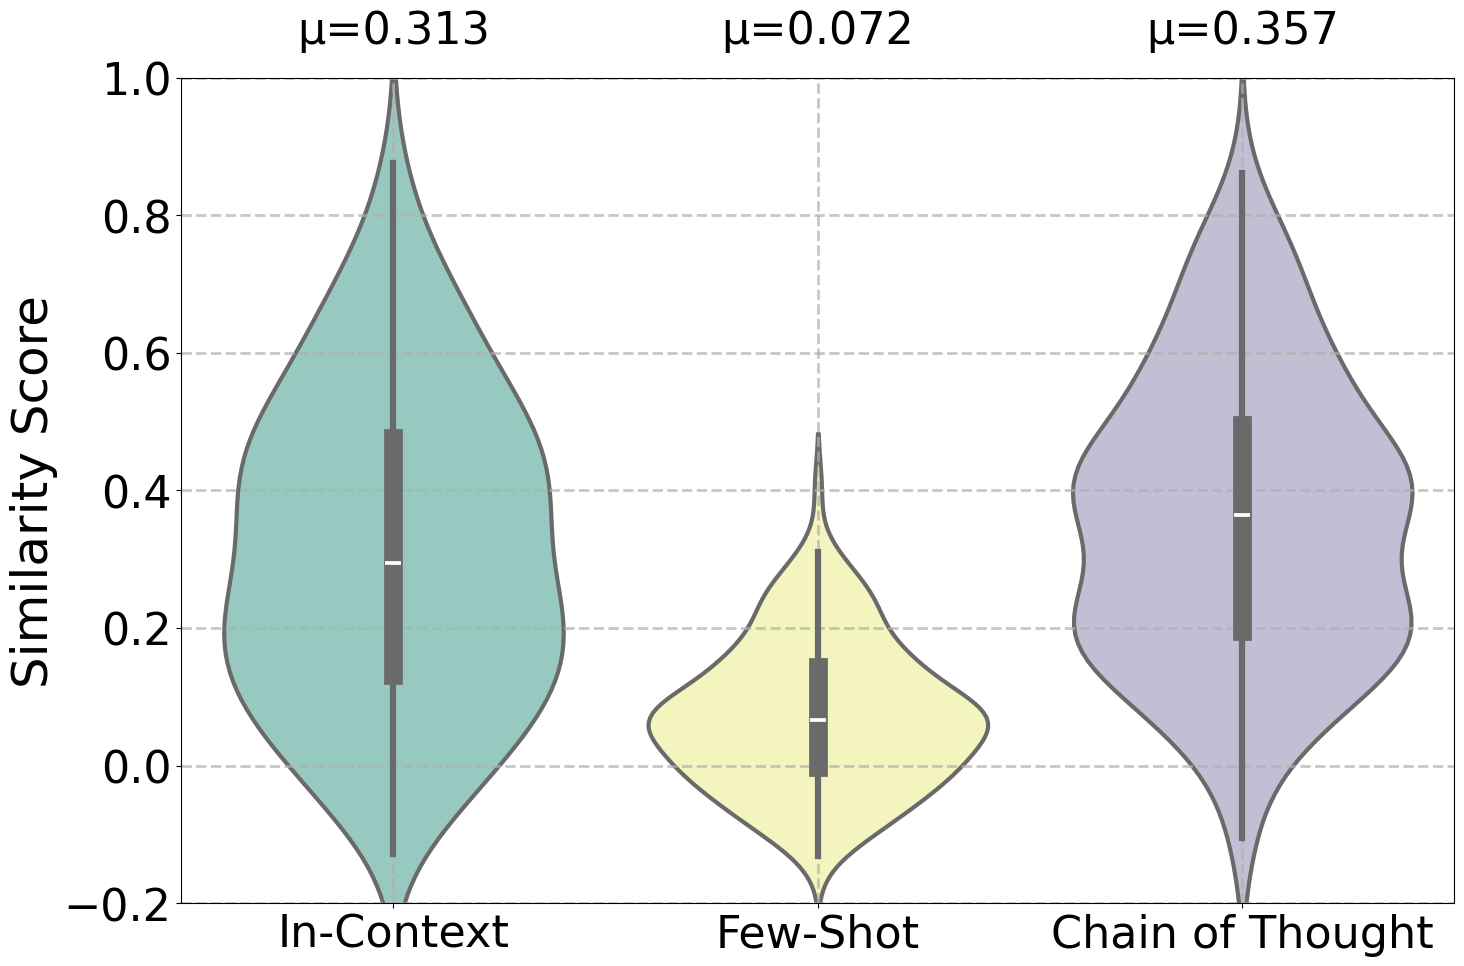


Statistical Summary for Combined Similarity (MiniLM):
       In-Context    Few-Shot  Chain of Thought
count  143.000000  143.000000        143.000000
mean     0.313258    0.072428          0.356533
std      0.225197    0.105036          0.207650
min     -0.128491   -0.131273         -0.105576
25%      0.132143   -0.001574          0.195196
50%      0.294602    0.066393          0.363916
75%      0.476511    0.143430          0.495357
max      0.875679    0.405257          0.861002


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def create_combined_violinplot(df, model_name="MiniLM"):
    # Create figure with larger size
    plt.figure(figsize=(15, 10))  # Increased figure size
    
    # Prepare data for combined similarity
    data = {
        'In-Context': df['similarity_zero_shot_combined'],
        'Few-Shot': df['similarity_few_shot_combined'],
        'Chain of Thought': df['similarity_cot_combined']
    }
    
    # Create DataFrame for seaborn
    plot_data = pd.DataFrame(data)
    
    # Create violin plot with embedded boxplot
    sns.violinplot(data=plot_data, 
                  palette='Set3',
                  inner='box',  # Show boxplot inside violin
                  linewidth=3.0,
                  saturation=0.7)
    
    # Customize plot with much larger text
    plt.ylabel('Similarity Score', fontsize=36)  # Increased y-label size
    plt.grid(True, linestyle='--', alpha=0.7, linewidth=2)
    plt.ylim(-0.2, 1.0)
    
    # Increase x-axis labels size
    plt.xticks(fontsize=32)  # Much larger x-axis text
    
    # Increase y-axis labels size
    plt.yticks(fontsize=32)  # Much larger y-axis text
    
    # Add mean values as text on top with larger font
    means = plot_data.mean()
    for i, technique in enumerate(['In-Context', 'Few-Shot', 'Chain of Thought']):
        mean_val = means[technique]
        plt.text(i, 1.05, f'μ={mean_val:.3f}', 
                horizontalalignment='center', fontsize=32)  # Much larger mean values
    
    # Adjust layout with more padding
    plt.tight_layout(pad=2.0)
    
    # Save plot as PDF with higher DPI - note the Llama path
    plt.savefig(f'Data/llama-3.2/llama_violinplot_combined_similarity_{model_name.lower()}.pdf', 
                format='pdf', bbox_inches='tight', dpi=600)
    plt.show()
    
    # Print statistical summary
    print(f"\nStatistical Summary for Combined Similarity ({model_name}):")
    df_stats = pd.DataFrame(data).describe()
    print(df_stats)
    
    # Return the statistical summary for further analysis if needed
    return df_stats

# Load and process Llama data
df = pd.read_csv('Data/llama-3.2/llm_responses_with_similarities_st_minilm.csv')
stats = create_combined_violinplot(df)